In [240]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


For the Governement of Tanzania, to tell them the best spend their resources. Wells that need reapir.

t1 - Wated Trip, well is good

t2 - Negelcting a well that needs fixing

primary target - recall on non functional wells, fewer false negatives on non functional wells

second target - precision on functional needing repair

Test Size - .2

Random State - 42

cv - 10

Shuffle - True (sklear kfold)

In [208]:
predictors = pd.read_csv('training_set_values.csv', index_col="id")
labels = pd.read_csv('training_set_labels.csv', index_col="id")

In [209]:
#drop date_recorded
predictors.drop('date_recorded', axis=1)

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
27263,4700.0,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
37057,0.0,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump


One Hot Encode - List of columns to OHE
Number of Value Counts per column
amount_tsh - 96 cont?
funder - 1987
gps_height - Cont
installer - 2145
lat/long - cont
wpt_name - 37400
basin - 9
sub village - 19287
region - 21
region_code - 27 cont?
district_code - 20 cont?
lga - 125
ward - 2092
population - cont
public_meeting - 2
recorded_by - 1
scheme_management - 12
scheme_name - 2696
permit - 2
construction_year - cont
extraction_type - 18
extraction_type_group - 13
extraction_type_class - 7
management - 12
management_group - 5
payment - 7
payment_type - 7
water_quality - 8
quality_group - 5
quantity - 5
quantity_group - 5
source - 10
source_type - 7
source_class - 3
waterpoint_type - 7
waterpoint_type_group - 6

Drop - date recorded



In [210]:
#create X and y
X = predictors
y = labels

In [211]:
#changes values of status_group to numerical
y['status_group'] = y['status_group'].replace(to_replace=['non functional','functional needs repair','functional'],
                                              value=[0,1,2])

y.head()


,status_group
id,
69572,2
8776,2
34310,2
67743,0
19728,2


In [212]:
#splits X and y for cat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [213]:
#X_train.reset_index(inplace=True)
#y_train.reset_index(inplace=True)

In [214]:
#splitting 
X_train_num = X_train.select_dtypes(exclude="object")
X_train_cat = X_train.select_dtypes(include="object")
X_test_num = X_test.select_dtypes(exclude="object")
X_test_cat = X_test.select_dtypes(include="object")

In [215]:
#replace NAs with "Missing"
#X_train_all_features = X_train_c.dropna(axis=0)
#X_train_all_features.isna().sum()
X_tr_cat_dr = X_train_cat.drop(["wpt_name", "date_recorded", "funder", "installer", "subvillage", "public_meeting", "scheme_management", "scheme_name", "permit"], axis=1)
X_test_cat_dr = X_test_cat.drop(["wpt_name", "date_recorded", "funder", "installer", "subvillage", "public_meeting", "scheme_management", "scheme_name", "permit"], axis=1)
print(X_tr_cat_dr.isna().sum().sum())
print(X_test_cat_dr.isna().sum().sum())

0
0


In [216]:
#OneHotEncoding train categorial columns
ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

ohe.fit(X_tr_cat_dr)

hot_cats = ohe.transform(X_tr_cat_dr)

hot_cats = pd.DataFrame(hot_cats, columns=ohe.get_feature_names(X_tr_cat_dr.columns), index=X_tr_cat_dr.index)
#no nans at this point
#index is being reset by OHE

X_train_ohe = pd.concat([X_train_num, hot_cats], axis=1)

X_train_ohe.shape

(47520, 2367)

In [217]:
X_train_ohe.isna().sum().sum()

0

In [218]:
X_test_cat_dr.isna().sum().sum()

0

In [221]:
#OneHotEncoding test categorial columns
hot_cats_test = ohe.transform(X_test_cat_dr)
hot_cats_test = pd.DataFrame(hot_cats_test, columns=ohe.get_feature_names(X_test_cat_dr.columns), index=X_test_cat_dr.index)

X_holdout =  pd.concat([X_test_num, hot_cats_test], axis=1)

X_holdout.shape

(11880, 2367)

In [222]:
X_holdout.isna().sum().sum()

0

*XGBoost*

In [224]:
# Instantiate XGBClassifier
XGB = XGBClassifier()

# Fit XGBClassifier
XGB.fit(X_train_ohe, y_train)

# Predict on training and test sets
training_preds = XGB.predict(X_train_ohe)
test_preds = XGB.predict(X_holdout)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


NameError: name 'training_f1' is not defined

In [ ]:
# Accuracy of training and test sets
training_f1 = f1_score(y_train, training_preds, average='none')
test_f1 = f1_score(y_test, test_preds, average='none')

training_recall = recall_score(y_train, training_preds, average='none')
test_recall = recall_score(y_test, test_preds, average='none')

print('Training F1: {:.4}%'.format(training_f1 * 100))
print('Validation F1: {:.4}%'.format(test_f1 * 100))

print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Validation Recall: {:.4}%'.format(test_recall * 100))

In [243]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))

[[3224   38 1310]
 [ 125  201  525]
 [ 454   66 5937]]
              precision    recall  f1-score   support

           0       0.85      0.71      0.77      4572
           1       0.66      0.24      0.35       851
           2       0.76      0.92      0.83      6457

    accuracy                           0.79     11880
   macro avg       0.76      0.62      0.65     11880
weighted avg       0.79      0.79      0.77     11880



In [ ]:
cross_val_score (XGB, X_train_ohe, y_train, cv=10, scoring='f1')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [ ]:
#XGBoost params
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [233]:
#random forest
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5) 
tree_clf.fit(X_train_ohe, y_train)

DecisionTreeClassifier(max_depth=5)

In [241]:
# Test set predictions
pred = tree_clf.predict(X_holdout)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2302    6 2264]
 [ 110   43  698]
 [ 351   20 6086]]
              precision    recall  f1-score   support

           0       0.83      0.50      0.63      4572
           1       0.62      0.05      0.09       851
           2       0.67      0.94      0.79      6457

    accuracy                           0.71     11880
   macro avg       0.71      0.50      0.50     11880
weighted avg       0.73      0.71      0.67     11880



In [234]:
# Feature importance
tree_clf.feature_importances_

array([0.05593326, 0.        , 0.01908488, ..., 0.00040125, 0.        ,
       0.25855673])

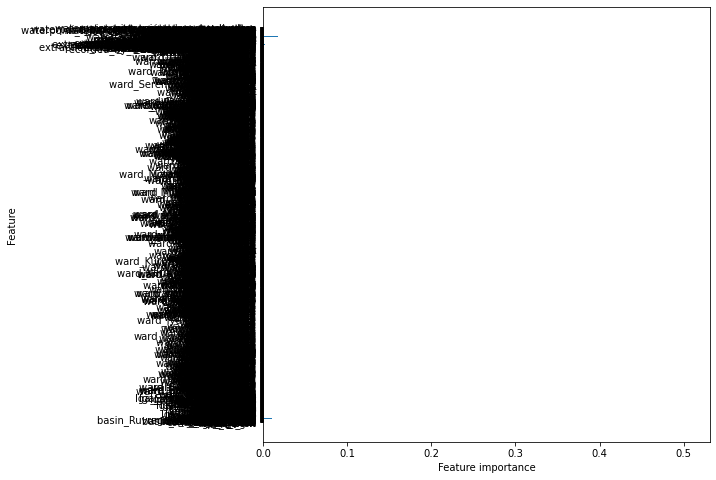

In [236]:
def plot_feature_importances(model):
    n_features = X_train_ohe.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_ohe.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

In [ ]:
#Recall on class 0